In [58]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
from typing import Optional
from itertools import product
from math import ceil

In [59]:
# energy specific fuel prices are not
SCENARIO = "static" # "static" | "dynamic"

In [60]:
DATA = Path("..","data","processed", SCENARIO) 
FIGURES = Path("..","figures","heatmaps", SCENARIO) 
SECTORS = ["E", "H", "EH"]
PRICES = ["high", "mid", "low", "vlow"]
EMISSIONS = ["20", "35", "50"]
SECTOR_NICE_NAMES = {
    "E": "Electrical",
    "H": "Thermal",
    "EH": "Electrical\nand Thermal"
}
PRICE_NICE_NAMES = {
    "vlow": "Very\nLow",
    "low": "Low",
    "mid": "Mid",
    "high": "High"
}

In [61]:
def get_dataframe(emission: str, result: str, sector: Optional[str] = None, price: Optional[str] = None) -> pd.DataFrame:
    if not (sector or price):
        scenario = f"er{emission}"
    else:
        scenario = f"{sector}dr-{price}-er{emission}" 
    p = Path(DATA, scenario, "datapoint", f"{result}.csv")
    return pd.read_csv(p, index_col=0)

In [62]:
def get_template_dataframe() -> pd.DataFrame:
    prices = PRICES.copy()
    prices.insert(0, "None")
    sectors = SECTORS.copy()
    sectors.insert(0, "None")
    return pd.DataFrame([],
        index=sectors,
        columns=prices
    )
get_template_dataframe()

,None,high,mid,low,vlow
None,NaN,NaN,NaN,NaN,NaN
E,NaN,NaN,NaN,NaN,NaN
H,NaN,NaN,NaN,NaN,NaN
EH,NaN,NaN,NaN,NaN,NaN


In [63]:
def get_heatmap_data(result: str, metric: str) -> dict[str, pd.DataFrame]:
    data = {}
    for emission in EMISSIONS:
        hm = get_template_dataframe()
        for sector, price in product(SECTORS, PRICES):
            df = get_dataframe(
                emission=emission,
                result=result,
                sector=sector,
                price=price
            )
            datapoint = df.at[metric, "value"]
            hm.at[sector, price] = datapoint
        df = get_dataframe(emission=emission, result=result)
        datapoint = df.at[metric, "value"]
        hm.at["None", "None"] = datapoint
        data[f"er{emission}"] = hm.astype(float)
    return data

In [64]:
def generate_heatmap(data: dict[str, pd.DataFrame], scaler: Optional[float] = None, **kwargs) -> tuple[plt.figure, plt.axes]:
    
    if not scaler:
        scaler = 1
    
    ncols = 2
    nrows = ceil(3 / ncols)
    
    ylabel = kwargs.get("ylabel", "")
    
    fig, axs = plt.subplots(nrows, ncols, figsize=(12, 5 * nrows))
    
    row = 0
    col = 0
    
    title = kwargs.get("title", "")
    if title:
        fig.suptitle(title, fontsize=20)
        
    custom_title = kwargs.get("custom_title", "")
    
    for er, df in data.items():
        
        # df = df[["high", "mid", "low", "None"]].T
        df = df.T.rename(index=PRICE_NICE_NAMES).rename(columns=SECTOR_NICE_NAMES)
        
        if custom_title:
            title = custom_title
        else:
            title = f"{er[-2:]}% Emission Reduction"
        
        df = df.div(scaler).round(2)
        
        hm = sns.heatmap(df, annot=True, cmap="crest", ax=axs[row, col], fmt=".1f")
        
        if ylabel:
            colorbar = hm.collections[0].colorbar
            colorbar.ax.set_ylabel(ylabel, rotation=0, labelpad=10, y=-0.05)
        
        axs[row, col].set_title(title, fontsize=14)
        axs[row, col].tick_params(axis="y", labelrotation=0)
        
        col += 1
        if col > 1:
            col = 0
            row += 1
        
    if col != 0:
        axs[row, 1].axis('off')
        
    plt.tight_layout(rect=[0, 0, 1, 0.99])
        
    return fig, axs

In [65]:
def generate_heatmap_3col(data: dict[str, pd.DataFrame], scaler: Optional[float] = None, **kwargs) -> tuple[plt.figure, plt.axes]:
    
    if not scaler:
        scaler = 1
    
    ncols = 3
    nrows = 1
    
    fig, axs = plt.subplots(nrows, ncols, figsize=(6 * ncols, 6 * nrows))

    col = 0
    
    title = kwargs.get("title", "")
    if title:
        fig.suptitle(title, fontsize=20)
        
    custom_title = kwargs.get("custom_title", "")
    
    ylabel = kwargs.get("ylabel", "")
    
    for er, df in data.items():
        
        df = df.T.rename(index=PRICE_NICE_NAMES).rename(columns=SECTOR_NICE_NAMES)
        
        if custom_title:
            title = custom_title
        else:
            title = f"{er[-2:]}% Emission Reduction"
        
        df = df.div(scaler).round(2)
        
        if col == 0:
            yticklabels = True
        else:
            yticklabels = False
            
        hm = sns.heatmap(
            df, 
            annot=True, 
            cmap="crest", 
            ax=axs[col], 
            fmt=".1f", 
            yticklabels=yticklabels,
            annot_kws={
                "fontsize":"x-large"
            }
        )

        colorbar = hm.collections[0].colorbar
        colorbar.ax.tick_params(labelsize=14)
        if ylabel:
            colorbar.ax.set_ylabel(ylabel, rotation=90, labelpad=10, y=0.5, fontsize=16)
        
        axs[col].set_title(title, fontsize=18, pad=20)
        
        axs[col].tick_params(axis="y", labelrotation=0, labelsize=14)
        axs[col].tick_params(axis="x", labelrotation=45, labelsize=14)
        
        col += 1
        
    plt.tight_layout(rect=[0, 0, 1, 0.99])
        
    return fig, axs

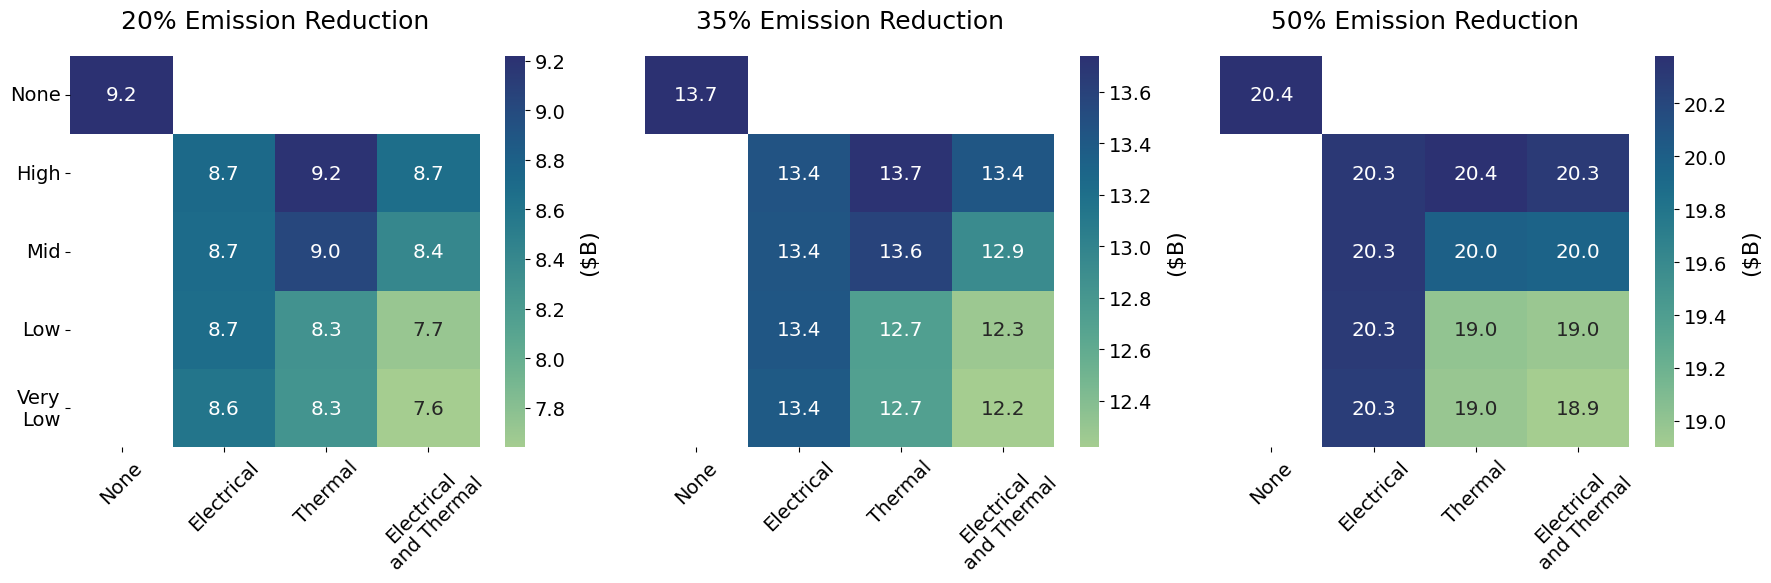

In [66]:
data = get_heatmap_data("cost", "objective_adj")
# fig, _ = generate_heatmap_3col(data, scaler=1e9, title="Objective Cost (B$)", ylabel="($B)")
fig, _ = generate_heatmap_3col(data, scaler=1e9, title="", ylabel="($B)")
fig.savefig(Path(FIGURES, "objective_cost.png"))

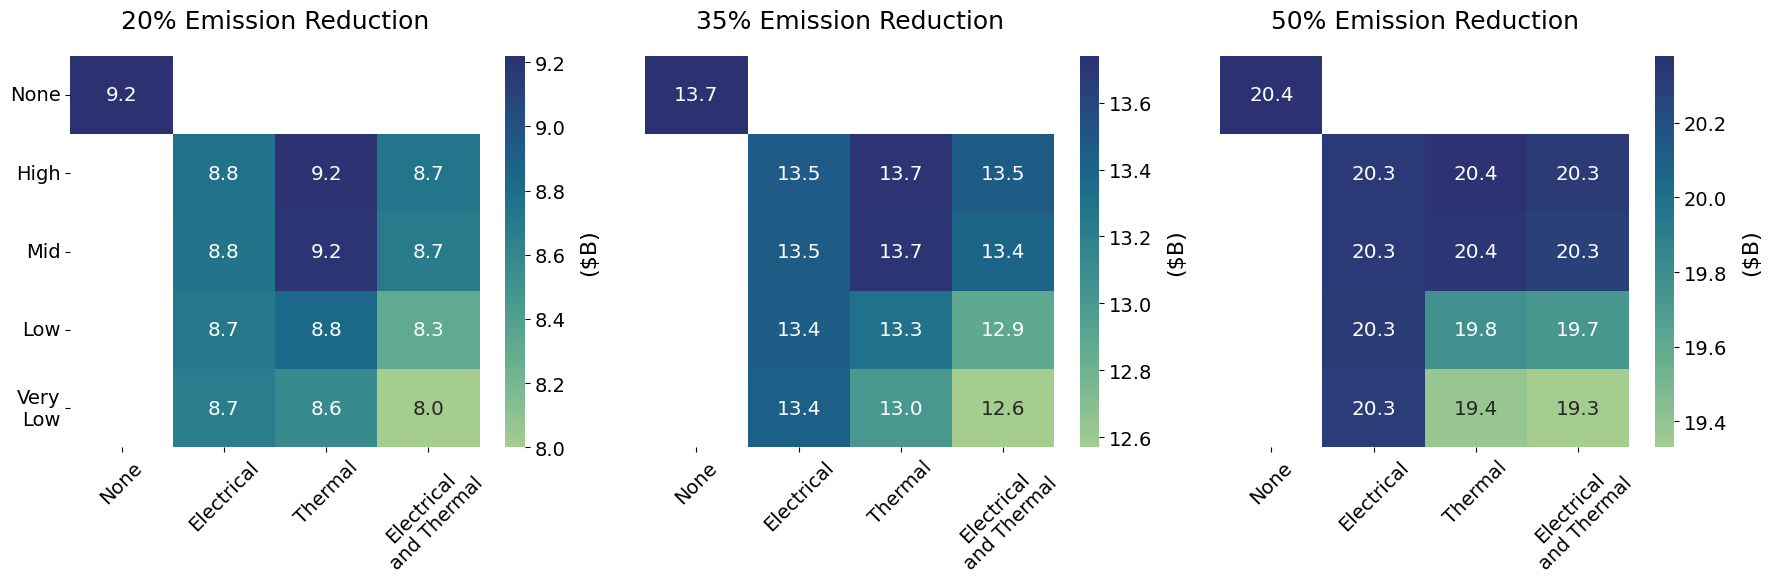

In [67]:
data = get_heatmap_data("cost", "objective")
# fig, _ = generate_heatmap_3col(data, scaler=1e9, title="Objective Cost Adjusted (B$)", ylabel="($B)")
fig, _ = generate_heatmap_3col(data, scaler=1e9, title="", ylabel="($B)")
fig.savefig(Path(FIGURES, "objective_cost_adj.png"))

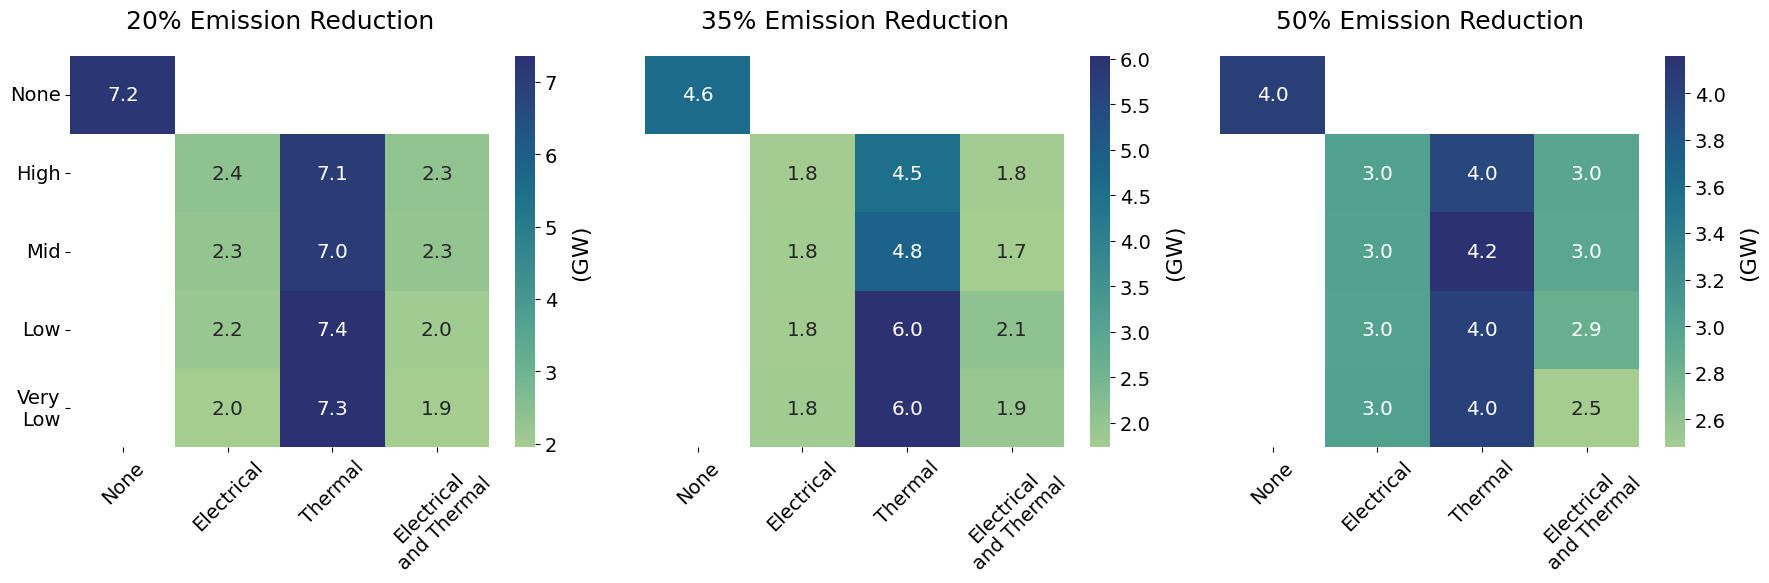

In [68]:
data = get_heatmap_data("peakiness", "peakiness")
# fig, _ = generate_heatmap_3col(data, scaler=1e3, title="Peakiness", ylabel="(GW)")
fig, _ = generate_heatmap_3col(data, scaler=1e3, ylabel="(GW)")
fig.savefig(Path(FIGURES, "peakiness.png"))

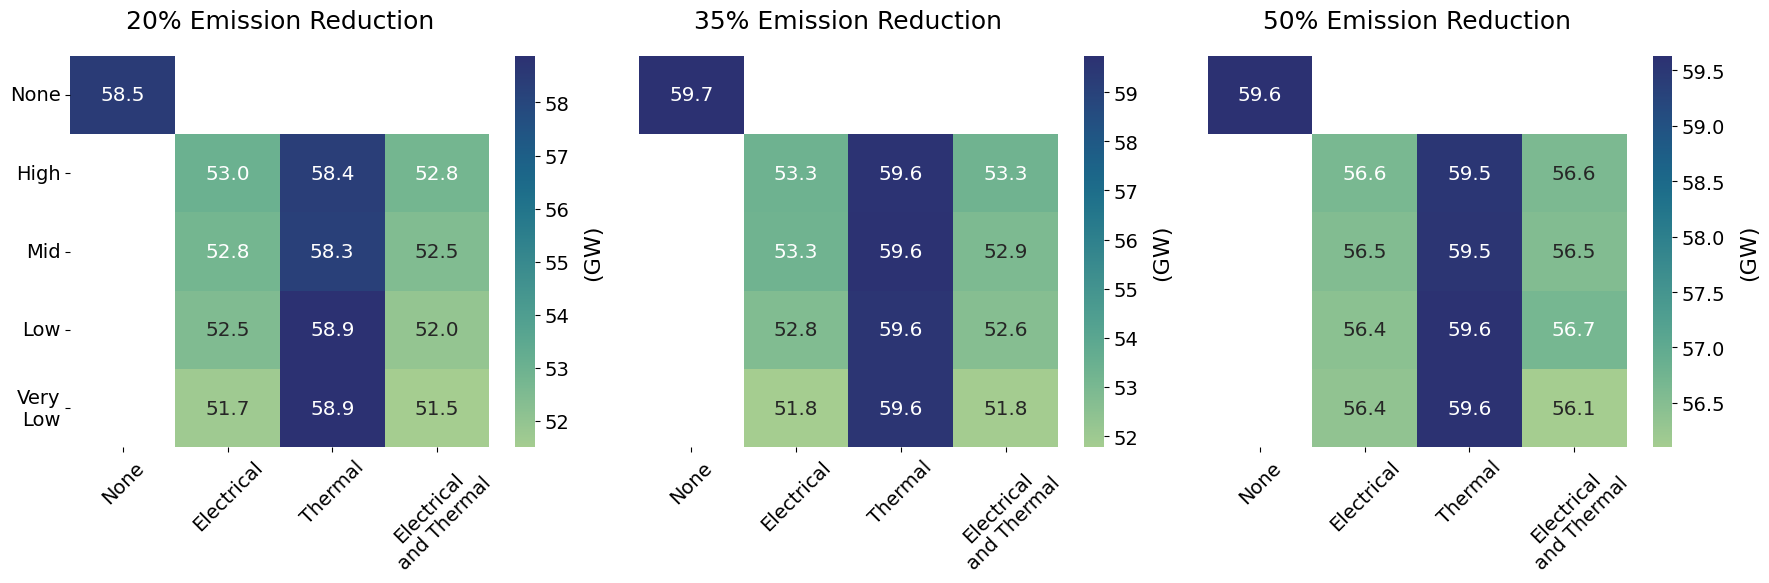

In [69]:
data = get_heatmap_data("peakiness", "peak")
# fig, _ = generate_heatmap_3col(data, scaler=1e3, title="Peak Net Load", ylabel="(GW)")
fig, _ = generate_heatmap_3col(data, scaler=1e3, ylabel="(GW)")
fig.savefig(Path(FIGURES, "peak_net_load.png"))

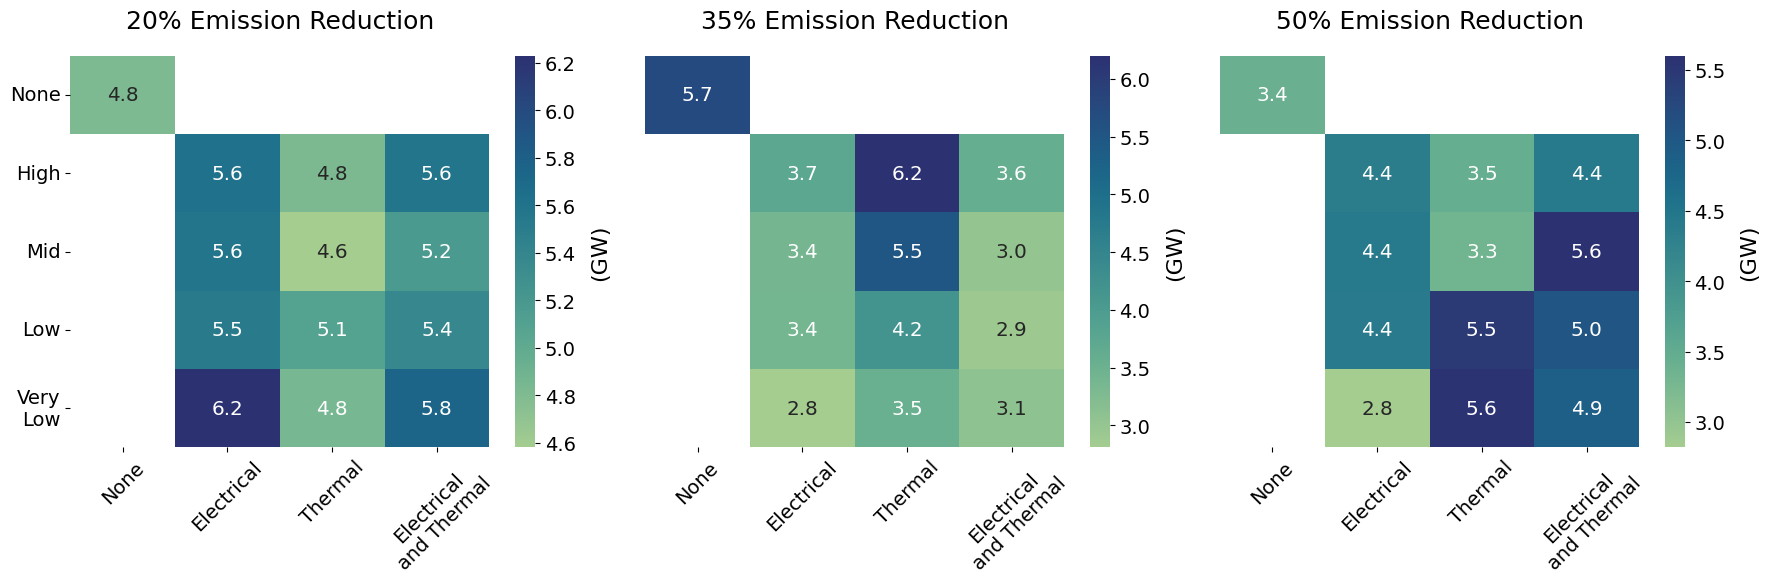

In [70]:
data = get_heatmap_data("ramping", "extreme")
# fig, _ = generate_heatmap_3col(data, scaler=1e3, title="Extreme Ramping", ylabel="(GW)")
fig, _ = generate_heatmap_3col(data, scaler=1e3, ylabel="(GW)")
fig.savefig(Path(FIGURES, "extreme_ramping.png"))

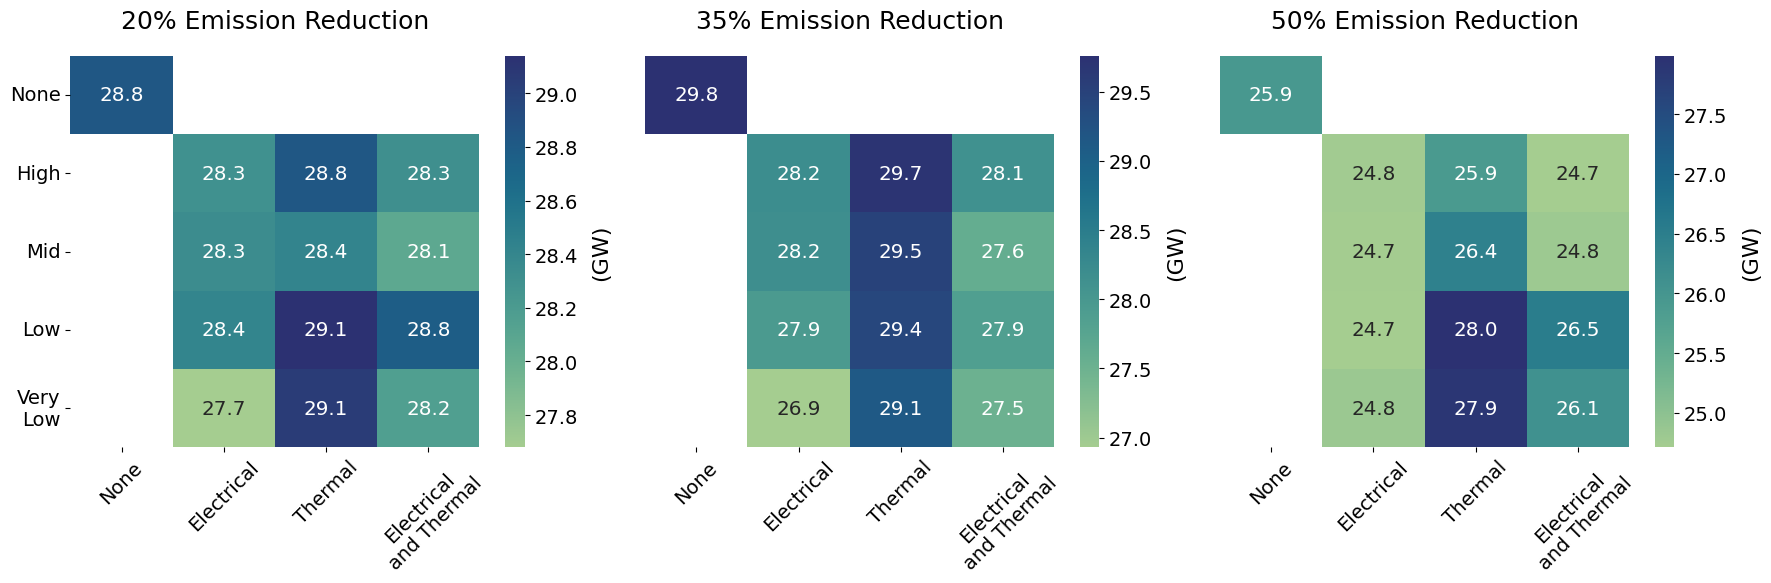

In [71]:
data = get_heatmap_data("ramping", "rountine")
# fig, _ = generate_heatmap_3col(data, scaler=1e3, title="Routine Ramping", ylabel="(GW)")
fig, _ = generate_heatmap_3col(data, scaler=1e3, ylabel="(GW)")
fig.savefig(Path(FIGURES, "routine_ramping.png"))

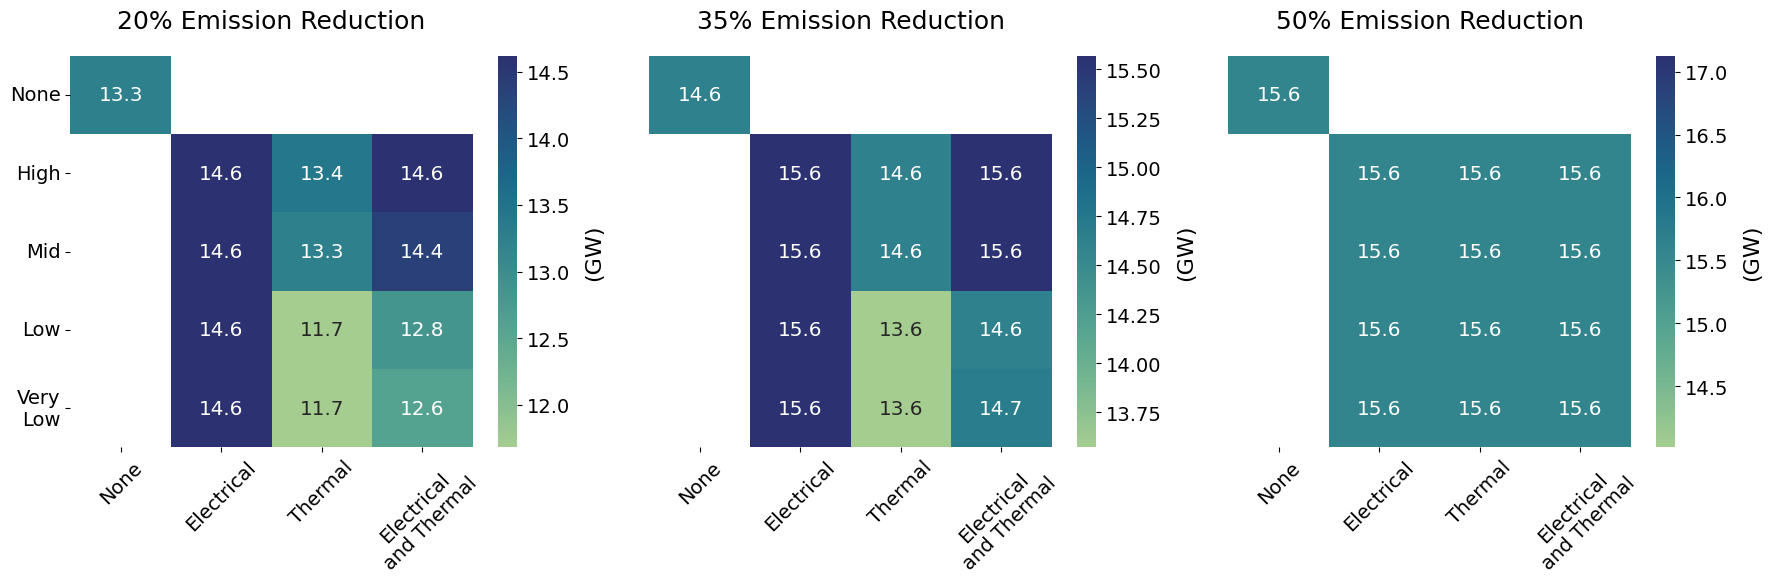

In [72]:
data = get_heatmap_data("capacity", "Wind")
# fig, _ = generate_heatmap_3col(data, scaler=1e3, title="Wind", ylabel="(GW)")
fig, _ = generate_heatmap_3col(data, scaler=1e3, ylabel="(GW)")
fig.savefig(Path(FIGURES, "wind_capacity.png"))

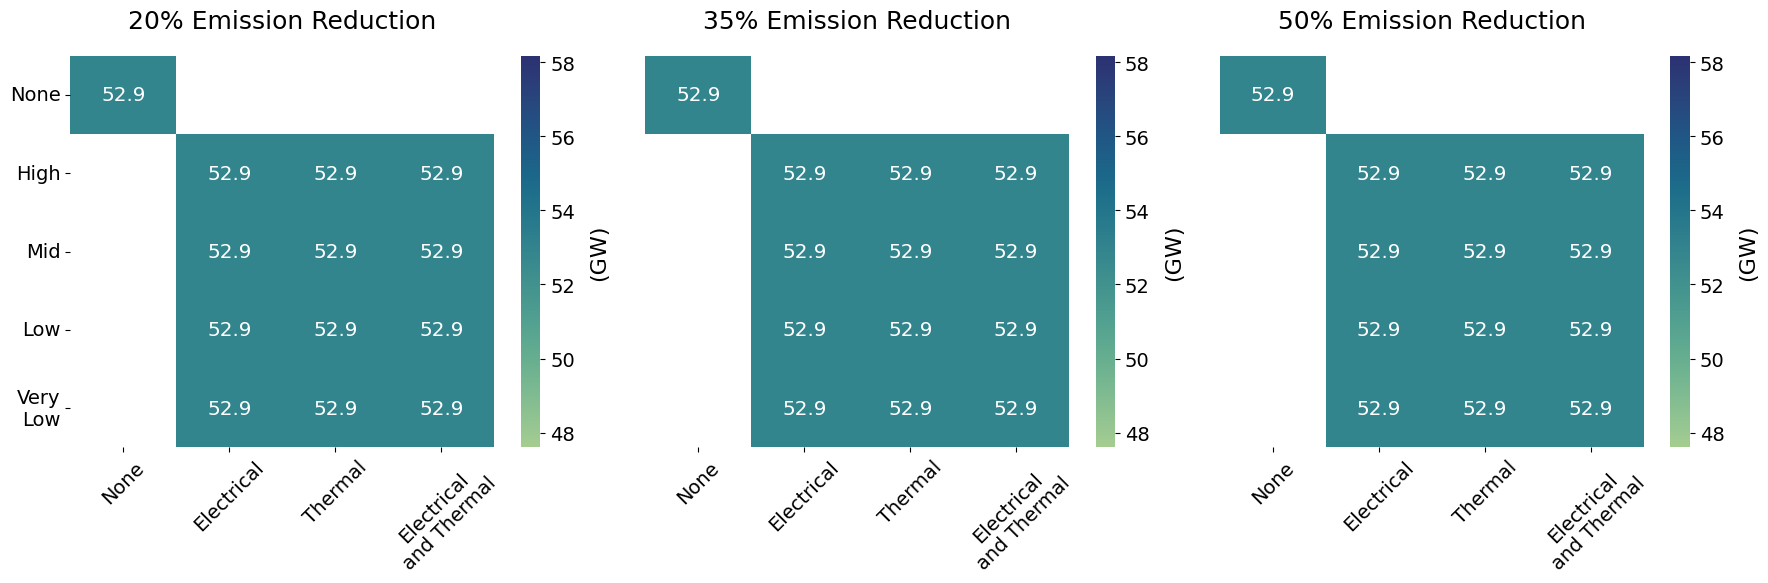

In [73]:
data = get_heatmap_data("capacity", "Solar")
# fig, ax = generate_heatmap_3col(data, scaler=1e3, title="Solar", ylabel="(GW)")
fig, _ = generate_heatmap_3col(data, scaler=1e3, ylabel="(GW)")
fig.savefig(Path(FIGURES, "solar_capacity.png"))

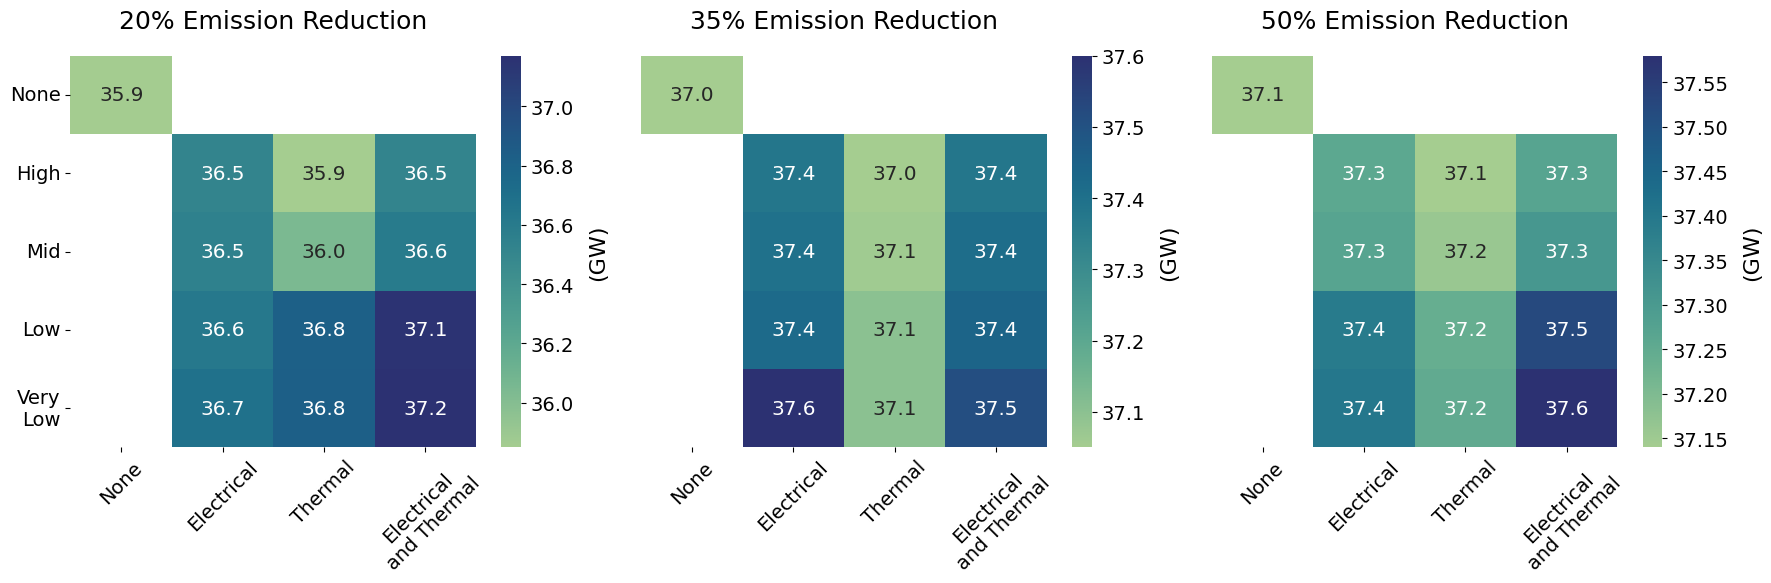

In [74]:
lgt = get_heatmap_data("capacity", "Transport Electric Light")
med = get_heatmap_data("capacity", "Transport Electric Medium")
hvy = get_heatmap_data("capacity", "Transport Electric Heavy")
bus = get_heatmap_data("capacity", "Transport Electric Bus")
data = {}
data["er20"] = lgt["er20"] + med["er20"] + hvy["er20"] + bus["er20"]
data["er35"] = lgt["er35"] + med["er35"] + hvy["er35"] + bus["er35"]
data["er50"] = lgt["er50"] + med["er50"] + hvy["er50"] + bus["er50"]
# fig, _ = generate_heatmap_3col(data, scaler=1e3, title="Electric Vehicles", ylabel="(GW)")
fig, _ = generate_heatmap_3col(data, scaler=1e3, ylabel="(GW)")
fig.savefig(Path(FIGURES, "total_evs.png"))

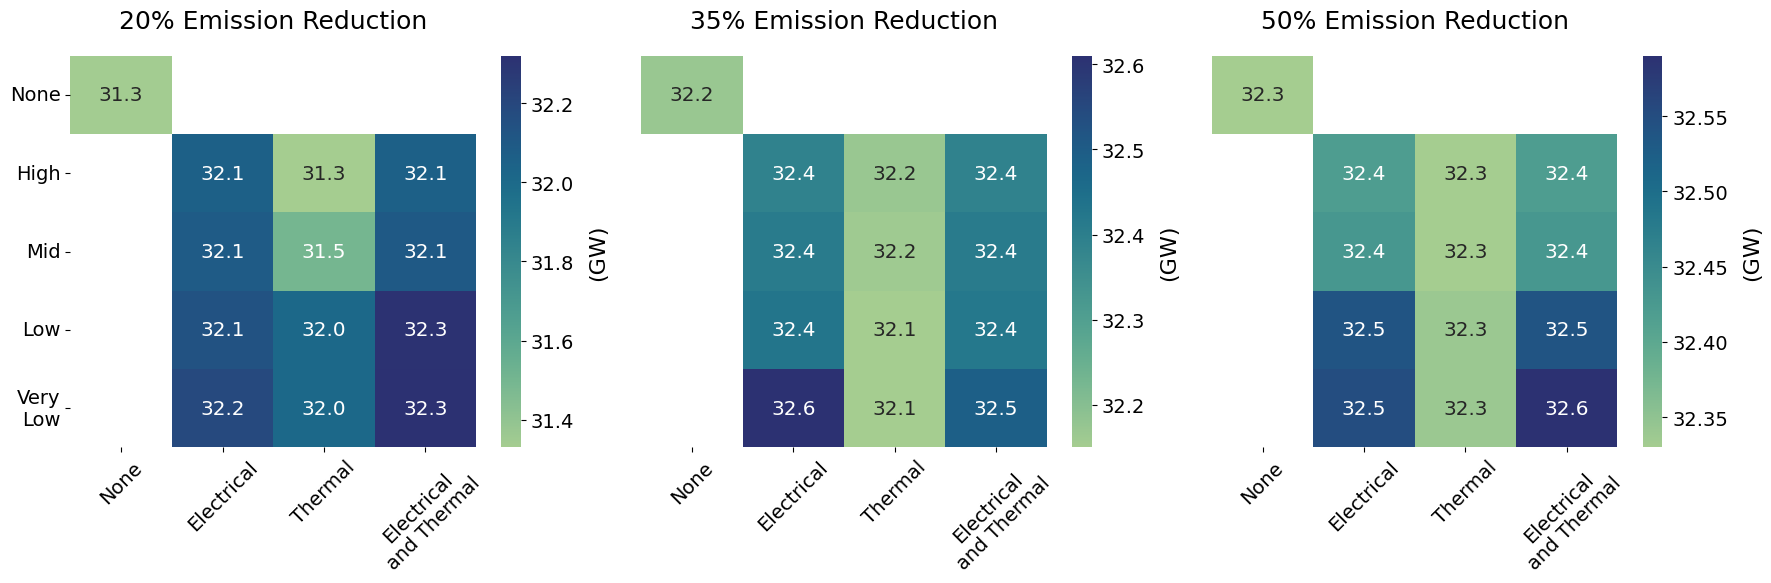

In [75]:
data = get_heatmap_data("capacity", "Transport Electric Light")
# fig, _ = generate_heatmap_3col(data, scaler=1e3, title="Light Duty Electric Vehicles", ylabel="(GW)")
fig, _ = generate_heatmap_3col(data, scaler=1e3, ylabel="(GW)")
fig.savefig(Path(FIGURES, "lgt_evs.png"))

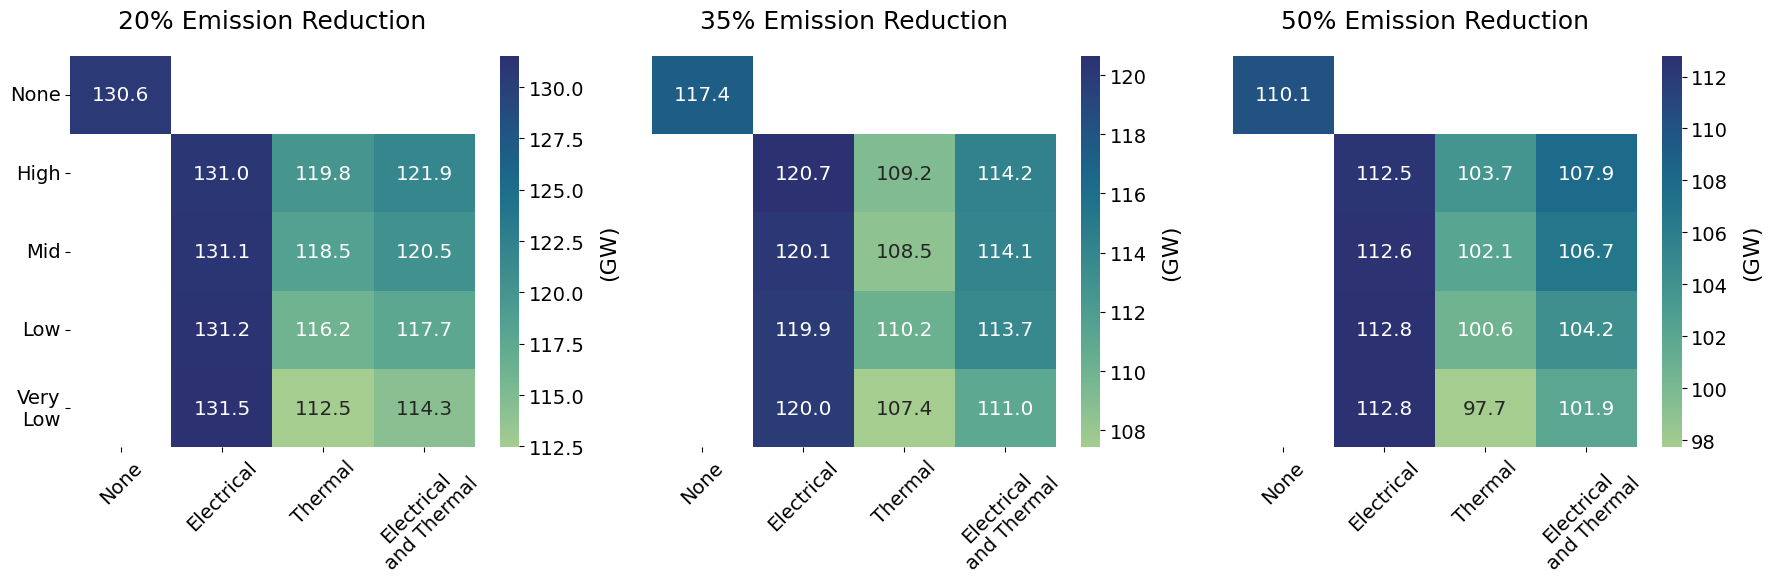

In [76]:
data = get_heatmap_data("capacity", "Service Gas Furnace")
# fig, _ = generate_heatmap_3col(data, scaler=1e3, title="Service Gas Furnace", ylabel="(GW)")
fig, _ = generate_heatmap_3col(data, scaler=1e3, ylabel="(GW)")
fig.savefig(Path(FIGURES, "service_gas_furnace.png"))

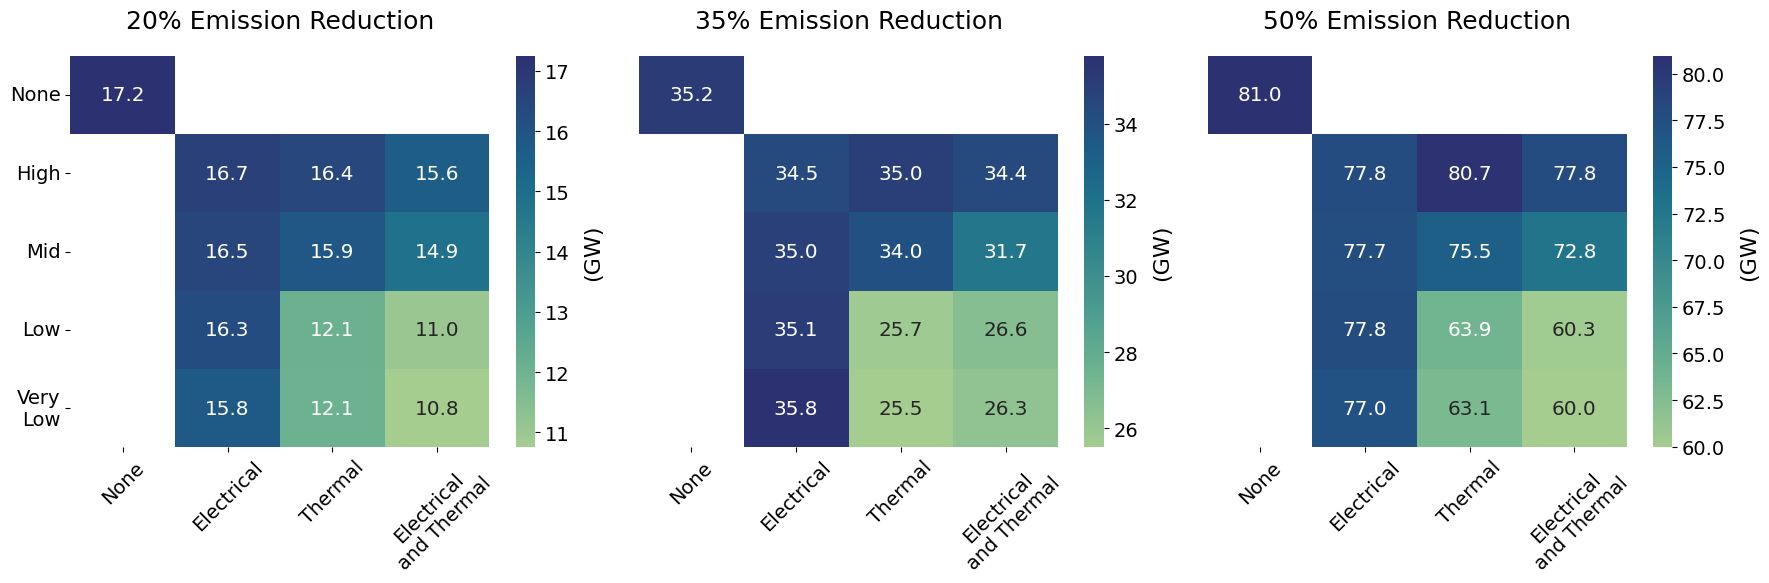

In [77]:
data = get_heatmap_data("capacity", "Service Heat Pump")
# fig, _ = generate_heatmap_3col(data, scaler=1e3, title="Service Heat Pump", ylabel="(GW)")
fig, _ = generate_heatmap_3col(data, scaler=1e3, ylabel="(GW)")
fig.savefig(Path(FIGURES, "service_heat_pump.png"))

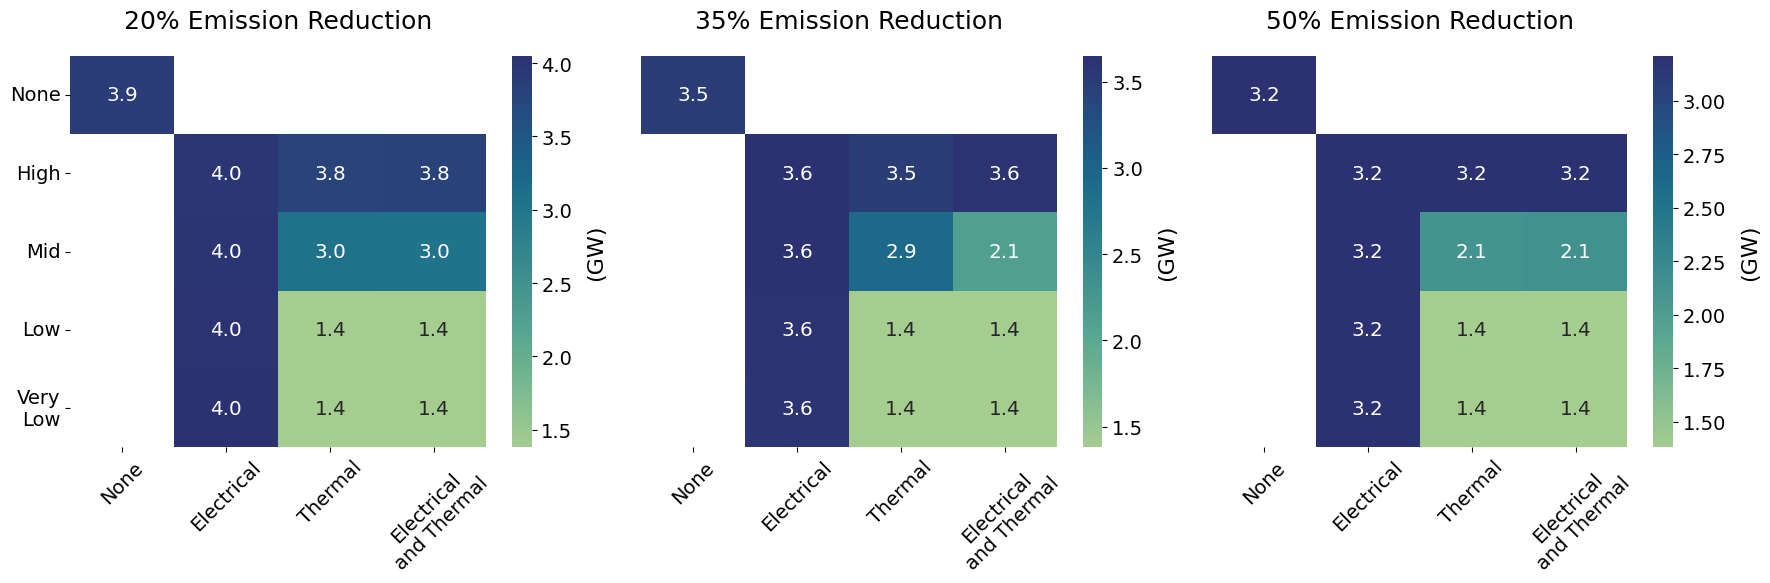

In [78]:
data = get_heatmap_data("capacity", "Service Air Conditioner")
# fig, ax = generate_heatmap_3col(data, scaler=1e3, title="Service Air Conditioner", ylabel="(GW)")
fig, _ = generate_heatmap_3col(data, scaler=1e3, ylabel="(GW)")
fig.savefig(Path(FIGURES, "service_air_conditioner.png"))

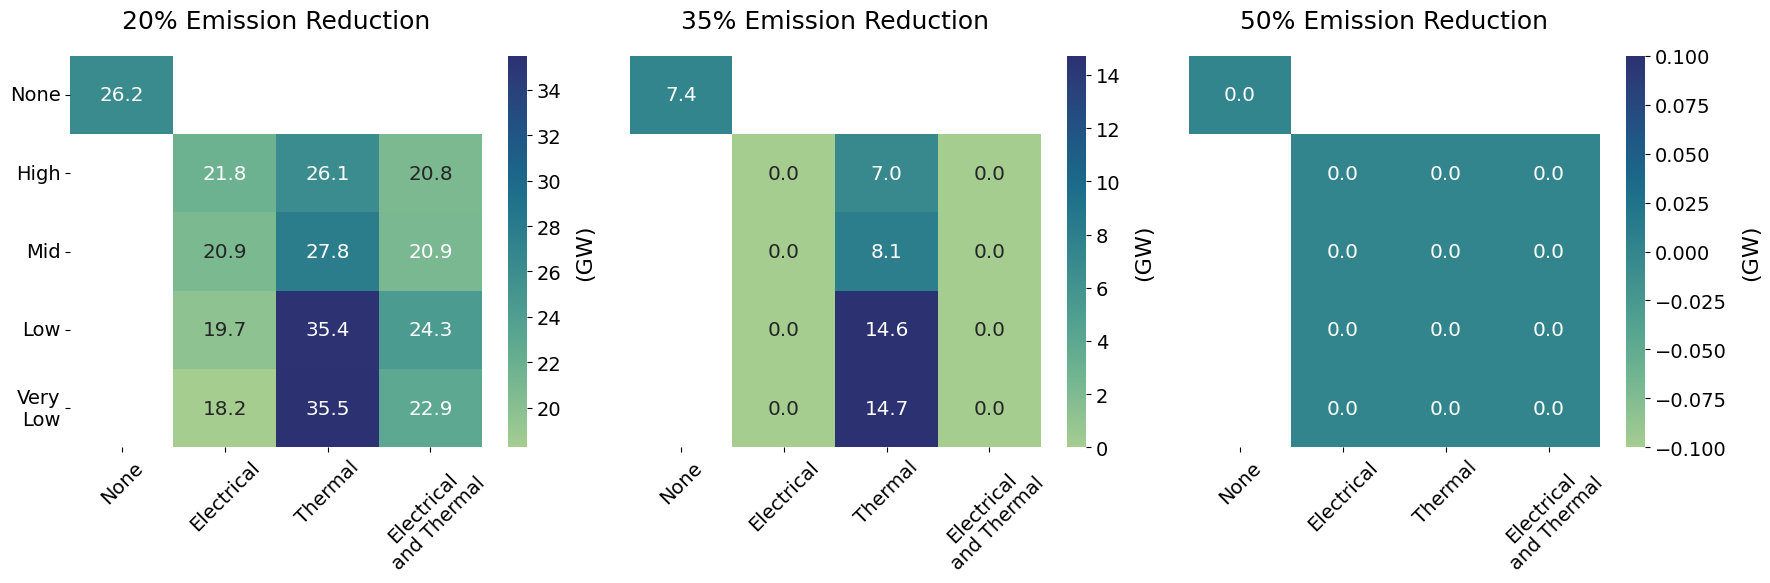

In [79]:
data = get_heatmap_data("capacity", "Natural Gas OCGT")
# fig, _ = generate_heatmap_3col(data, scaler=1e3, title="Natural Gas OCGT", ylabel="(GW)")
fig, _ = generate_heatmap_3col(data, scaler=1e3, ylabel="(GW)")
fig.savefig(Path(FIGURES, "ocgt_capacity.png"))

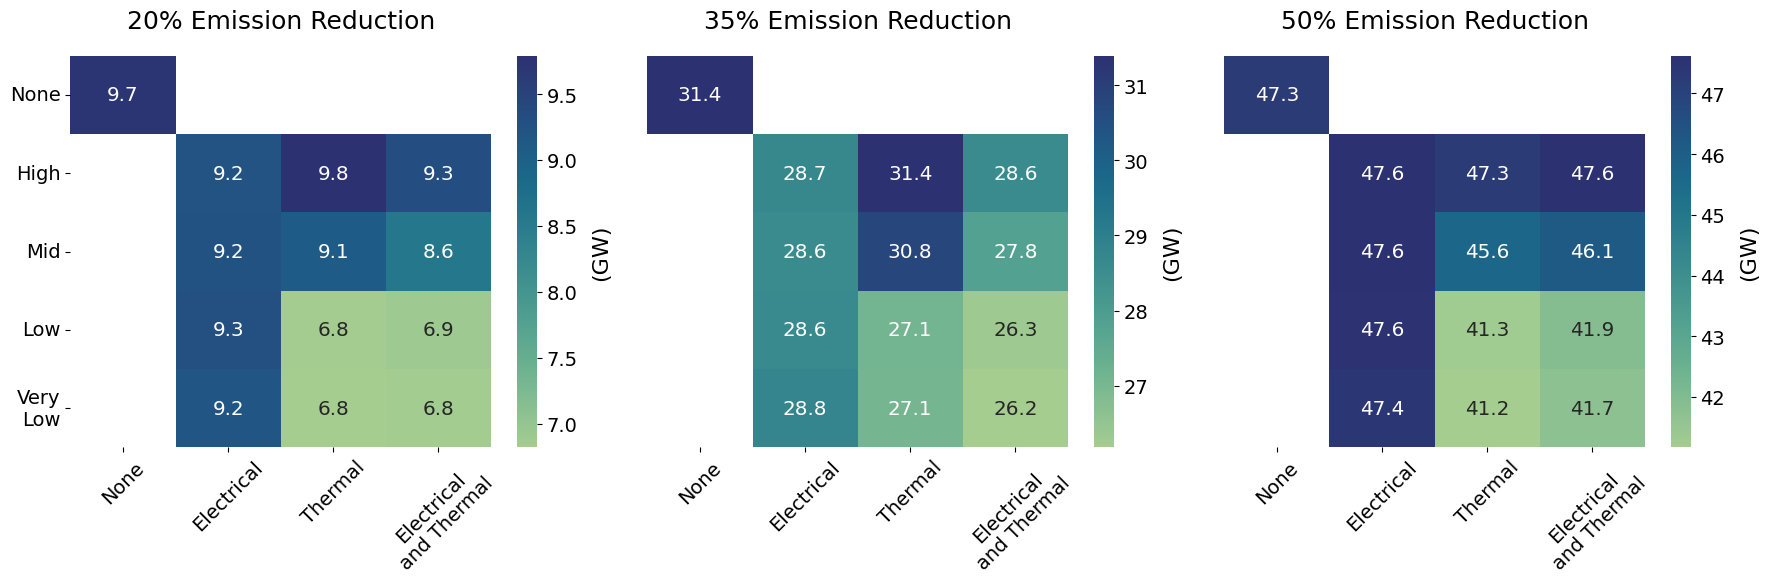

In [80]:
data = get_heatmap_data("capacity", "Natural Gas CCGT-95CCS")
# fig, _ = generate_heatmap_3col(data, scaler=1e3, title="Natural Gas CCGT-95CCS", ylabel="(GW)")
fig, _ = generate_heatmap_3col(data, scaler=1e3, ylabel="(GW)")
fig.savefig(Path(FIGURES, "ccgt_95ccs_capacity.png"))

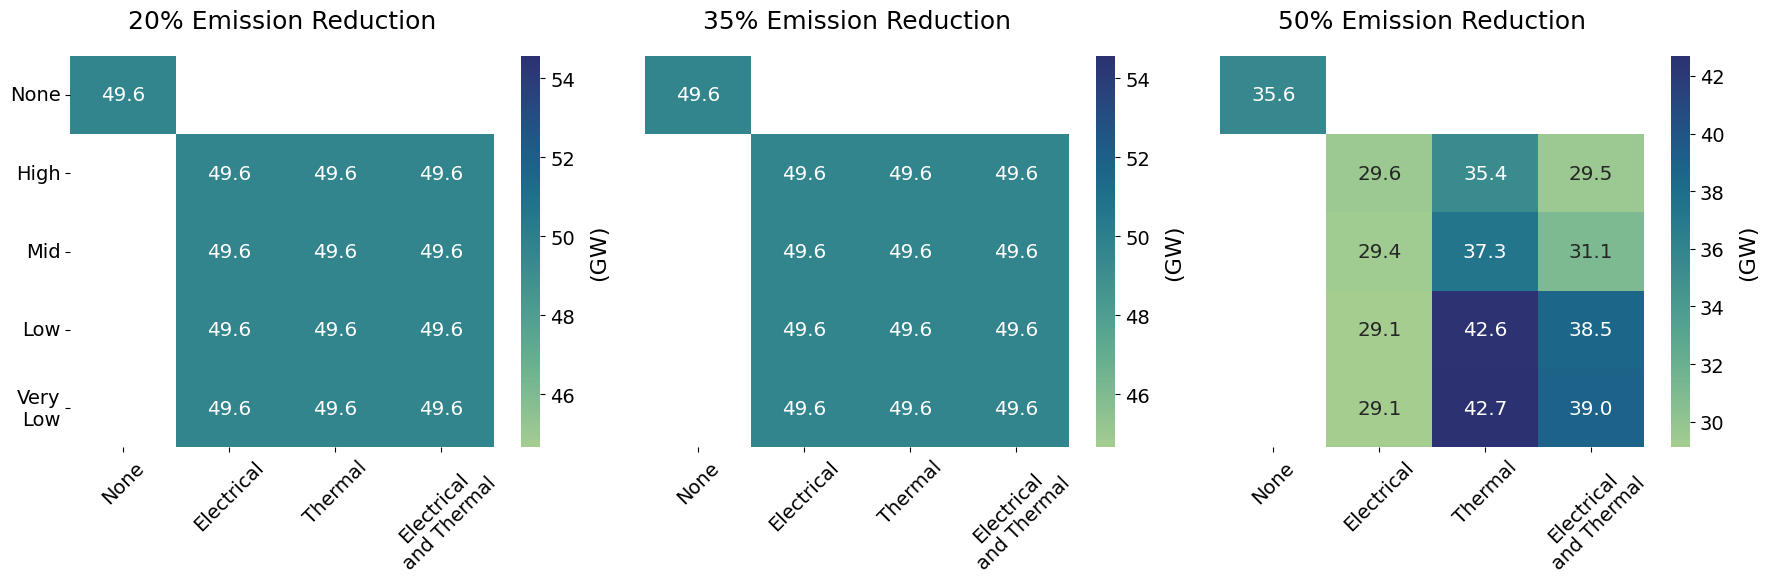

In [81]:
data = get_heatmap_data("capacity", "Natural Gas CCGT")
# fig, _ = generate_heatmap_3col(data, scaler=1e3, title="Natural Gas CCGT", ylabel="(GW)")
fig, _ = generate_heatmap_3col(data, scaler=1e3, ylabel="(GW)")
fig.savefig(Path(FIGURES, "ccgt_capacity.png"))

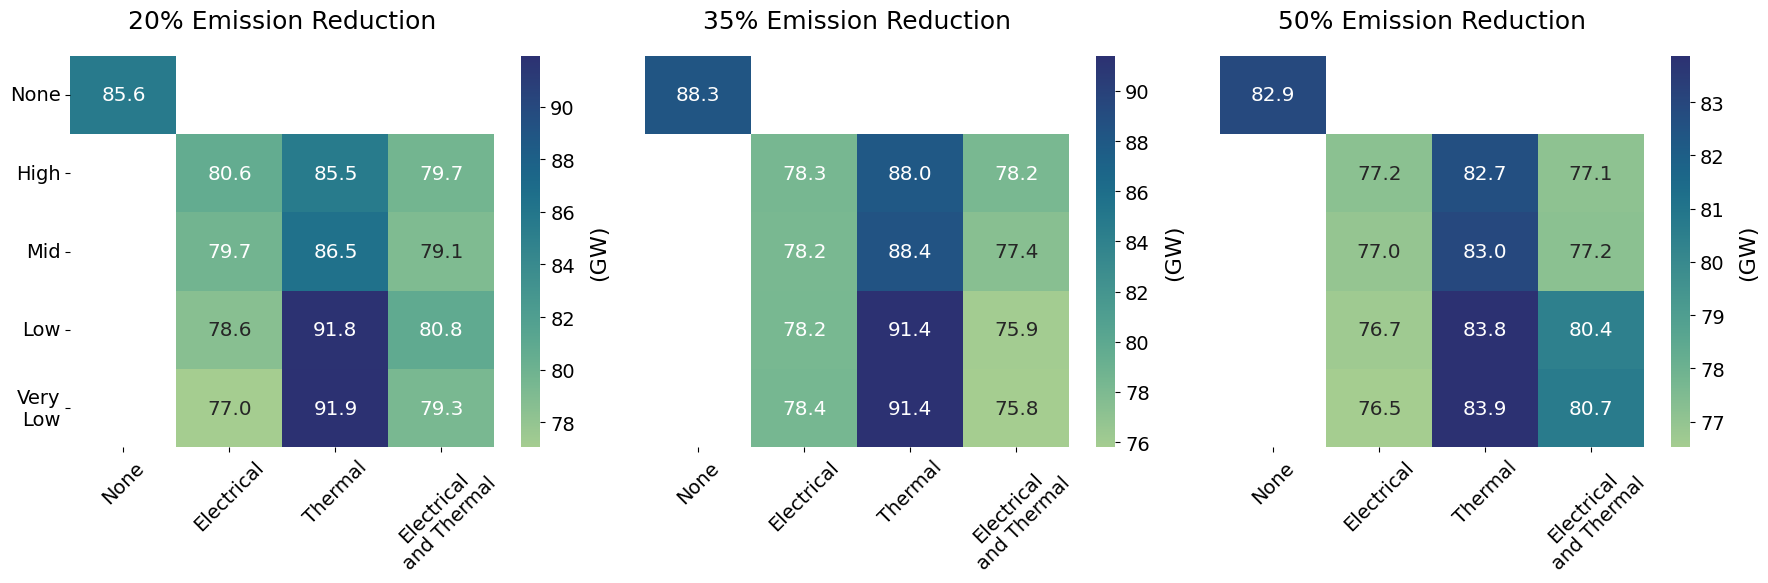

In [82]:
ocgt = get_heatmap_data("capacity", "Natural Gas OCGT")
ccgt = get_heatmap_data("capacity", "Natural Gas CCGT")
ccgtccs = get_heatmap_data("capacity", "Natural Gas CCGT-95CCS")
data = {}
data["er20"] = ocgt["er20"] + ccgt["er20"] + ccgtccs["er20"]
data["er35"] = ocgt["er35"] + ccgt["er35"] + ccgtccs["er35"]
data["er50"] = ocgt["er50"] + ccgt["er50"] + ccgtccs["er50"]
# fig, _ = generate_heatmap_3col(data, scaler=1e3, title="Natual Gas (GW)", ylabel="(GW)")
fig, _ = generate_heatmap_3col(data, scaler=1e3, ylabel="(GW)")
fig.savefig(Path(FIGURES, "total_ng_capacity.png"))